In [21]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
sns.set_theme(style='white')

from tqdm import tqdm

from scipy.stats import fisher_exact,ttest_ind
from statsmodels.stats.multitest import fdrcorrection

import warnings
warnings.filterwarnings("ignore")

samples = ['MET_A14','MET_GP12','MET_A3','MET_A16']

sample_crop_coord = {
     'MET_A14':(800,18500,2200,19800),
     'MET_GP12':(-400,17300,2000,19600),
     'MET_A3':(1700,19500,3200,20700),
     'MET_A16':(800,18700,700,18300),
        }

sample_palettes = {
     'MET_A14':'Dark2',
     'MET_GP12':'Accent',
     'MET_A3':'tab10',
     'MET_A16':'Paired'
        }

met_samples = {
    'MET_A14':'MET_A',
    'MET_GP12':'MET_B',
    'MET_A3':'MET_C',
    'MET_A16':'MET_D',
}   

region_colors_dict = {
 'Tumor': '#fc8d62',
 'Luminal epithelium': '#8da0cb',
 'Basal epithelium': '#66c2a5',
 'Club epithelium': '#ffd92f',
 'Immune': '#a6d854',
 'Endothelium': '#e78ac3',
 'Fibroblast': '#e5c494',
 'Muscle': '#b3b3b3'
 }

regions = list(region_colors_dict.keys())
region_colors = list(region_colors_dict.values())

gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T


## Data download

In [5]:
def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

def check_cluster_enrichment(dat,gene_signature,return_pvals=False):

    pvals_lst = []
    df_res = sc.get.rank_genes_groups_df(dat,group=None)
    for grp in df_res['group'].cat.categories.tolist():
        genes_lst = df_res[(df_res['group'] == grp) &
                            (df_res['logfoldchanges']>=1) &
                            (df_res['pvals_adj']<0.05)]['names'].tolist()

        total = dat.shape[1]

        deg_overlap = [s for s in gene_signature if s in genes_lst]
        a = len(deg_overlap)
        b = len(gene_signature) - a
        c = len(genes_lst) - a
        d = total - len(genes_lst) - b

        arr = np.array([[a,b],[c,d]])
        stat, pval = fisher_exact(arr,alternative='greater')

        if not return_pvals:        
            if pval < 0.05:
                print('cluster {} enrichment p-value: {:.2e} !!'.format(grp,pval))
                print('Overlap: {}'.format(' '.join(deg_overlap)))
            else:
                print('cluster {} enrichment p-value: {:.3f}'.format(grp,pval))
        
        pvals_lst.append(pval)

    if return_pvals:
        return(pvals_lst)

In [ ]:

# Cluster the normalized metastasis samples

for i,sample in enumerate(samples):

    adata = sc.read_h5ad('./data/normalized_visium/{}_normalized.h5ad'.format(sample))

    sc.pp.scale(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata,resolution=0.5) #

    adata.uns['log1p']["base"] = None
    sc.tl.rank_genes_groups(adata,groupby='leiden',method='wilcoxon')
    deg_res = sc.get.rank_genes_groups_df(adata,group=None)
    
    adata.write('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))
    del adata

## Clustering and gene set enrichment

In [65]:
# Format gene lists
club_markers = check_top_markers('Club epithelium')['gene'].tolist()
club_senescence = list(set(club_markers).intersection(gene_set_df['MP19 Epithelial Senescence']))

signatures_dict = {'Club region markers':club_markers,'Club-like senescence':club_senescence}

### Plot clusters on spatial for an individual sample

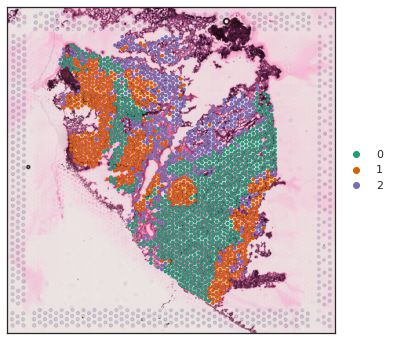

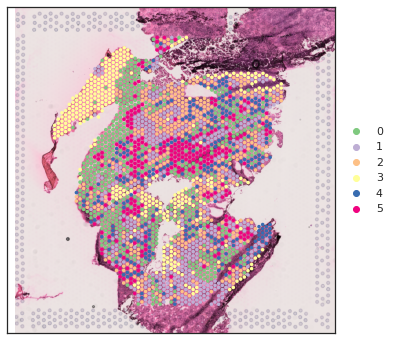

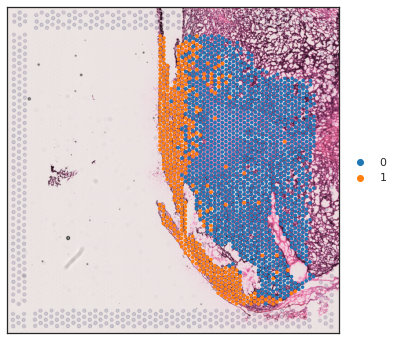

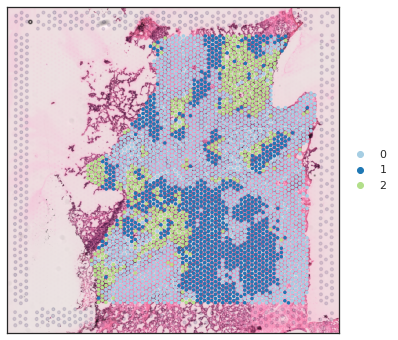

In [22]:
for sample in samples:

    sns.set_theme(style='white',palette=sample_palettes[sample])

    adata = sc.read_h5ad('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))

    fig,ax = plt.subplots(figsize=(6,6))
    #fig,ax = plt.subplots(figsize=(2,2))

    sc.pl.spatial(adata,color='leiden',
                            crop_coord=sample_crop_coord[sample],
                            size=1.3, alpha_img=1,show=False,ax=ax,
                            )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')

    #plt.savefig('./plots/met_samples/{}_clusters.png'.format(sample),dpi=1200)
    plt.show()


### A violin plot of cluster scores (Figure 5d)

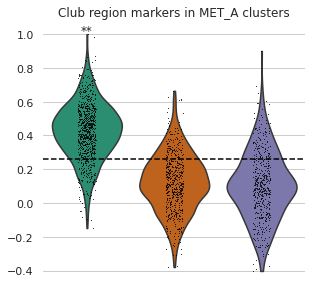

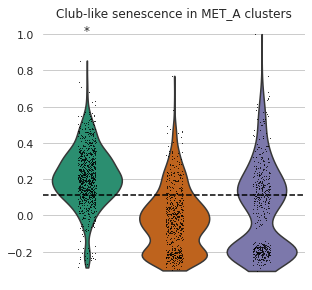

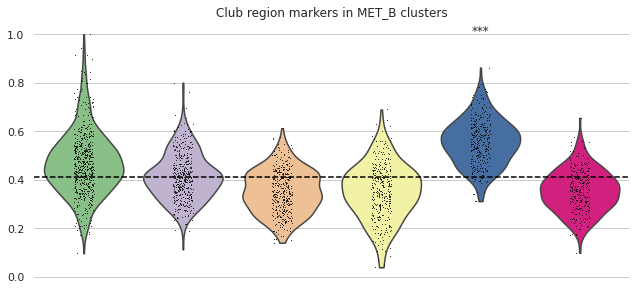

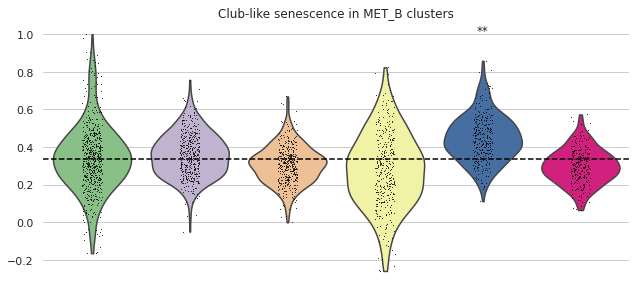

In [66]:

plot_df = pd.DataFrame()

for sample in samples[:2]:

    dat = sc.read_h5ad('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))

    for signature_name in signatures_dict:

        signature = signatures_dict[signature_name]

        sc.tl.score_genes(dat,gene_list=signature,score_name=signature_name,use_raw=True)

        dat.obs[signature_name] = dat.obs[signature_name]/dat.obs[signature_name].max() # Scale the scores

        cluster_order = dat.obs['leiden'].cat.categories.tolist()
        score_median = dat.obs[signature_name].median()

        sns.set_theme(style='whitegrid',palette=sample_palettes[sample])

        # Plot violins
        fig, ax = plt.subplots(figsize=(len(cluster_order)*1.5,4.2))

        ax.axhline(y=score_median,color='black',linestyle='--')

        sc.pl.violin(dat,keys=signature_name,groupby='leiden',
                    jitter=True,
                    ax=ax,show=False
                    )

        
        ax.set_xticklabels('')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f'{signature_name} in {met_samples[sample]} clusters')

        for cl in cluster_order:
            scores_cl = dat.obs[dat.obs['leiden']==cl][signature_name]
            scores_other = dat.obs[~(dat.obs['leiden']==cl)][signature_name]

            # Calculate t-test p-value
            stat, pval = ttest_ind(scores_cl,scores_other)

            cl_scores_desc = scores_cl.describe(percentiles=np.arange(0.1,1,0.1))

            if cl_scores_desc['10%'] >= score_median:
                ax.text(x=cl,y=1,s='***',ha='center')
            
            elif cl_scores_desc['20%'] >= score_median:
                ax.text(x=cl,y=1,s='**',ha='center')

            elif cl_scores_desc['30%'] >= score_median:
                ax.text(x=cl,y=1,s='*',ha='center')

        ax.set_frame_on(False)
        plt.tight_layout()
        plt.savefig('./plots/met_samples/{}_cluster_violins_{}.pdf'.format(sample,signature_name))
            
        plt.show()

    # Format the plot data into a df
    obs_data = dat.obs[['leiden'] + list(signatures_dict.keys())]
    obs_data['leiden'] = met_samples[sample] + (obs_data['leiden'].astype(int) + 1).astype(str)
    plot_df = pd.concat([plot_df,obs_data],axis=0)

# Save the plot source data
plot_df.reset_index(drop=True).to_excel('./source_data/figure_5d.xlsx')

## Create an enrichment dotplot

In [72]:
# Format gene lists
club_markers = check_top_markers('Club epithelium')['gene'].tolist()
club_senescence = list(set(club_markers).intersection(gene_set_df['MP19 Epithelial Senescence']))

signatures_dict = {
    'PMN-MDSC activity':gene_set_df['CD300LD downstream'].dropna().tolist(),
    'Epithelial senescence':gene_set_df['MP19 Epithelial Senescence'].dropna().tolist(),
    'Club region markers':club_markers,
    'Club-like senescence':club_senescence,
    'High NLR-associated':gene_set_df['High NLR-associated'].dropna().tolist()
    }

In [73]:
# Print out enrichments and their overlaps
for k in signatures_dict:
    print(k)
    for sample in samples:

        print(sample)
        adata = sc.read_h5ad('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))
        check_cluster_enrichment(adata,signatures_dict[k],return_pvals=False)
        print('\n')
    print('*************************\n')

PMN-MDSC activity
MET_A14
cluster 0 enrichment p-value: 7.58e-03 !!
Overlap: CHI3L1 C3 HSD11B1 HP SCP2 IFITM3 NAMPT
cluster 1 enrichment p-value: 1.000
cluster 2 enrichment p-value: 1.000


MET_GP12
cluster 0 enrichment p-value: 7.67e-06 !!
Overlap: XAF1 S100A8 S100A9 LCN2 ANXA1 PYGL EMILIN1 C3 C5AR1 F13A1 RAB31 IFITM3 ARHGDIB LGALS1 GSN
cluster 1 enrichment p-value: 0.605
cluster 2 enrichment p-value: 1.000
cluster 3 enrichment p-value: 5.24e-03 !!
Overlap: CHI3L1 SLPI
cluster 4 enrichment p-value: 3.60e-03 !!
Overlap: IFIT1 LCN2 CEACAM1
cluster 5 enrichment p-value: 1.000


MET_A3
cluster 0 enrichment p-value: 1.000
cluster 1 enrichment p-value: 0.760


MET_A16
cluster 0 enrichment p-value: 1.000
cluster 1 enrichment p-value: 2.89e-02 !!
Overlap: ANXA1 EMILIN1 IDH1 MCFD2 ALAS1 CD9 ZMPSTE24 ARHGDIB
cluster 2 enrichment p-value: 0.644


*************************

Epithelial senescence
MET_A14
cluster 0 enrichment p-value: 0.412
cluster 1 enrichment p-value: 1.000
cluster 2 enrichment p

In [102]:
# Calculate gene set enrichmnents scores for a set list of signatures and
# Peform multiple testing correction

enrichment_res_df = pd.DataFrame(index=signatures_dict.keys())
for sample in samples[:2]:

    dat = sc.read_h5ad('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))

    enrichment_pvalues_dict = {}
    for k in signatures_dict:
        pvals = check_cluster_enrichment(dat,signatures_dict[k],return_pvals=True)
        enrichment_pvalues_dict[k] = pvals

    res_df = pd.DataFrame(enrichment_pvalues_dict,
            index=[met_samples[sample]+ str(c) for c in list(np.arange(0,len(pvals))+1)]).T
    
    enrichment_res_df = pd.concat([enrichment_res_df,res_df],axis=1,ignore_index=False)

p_values = enrichment_res_df.values

# Perform FDR correction
reject, corrected_p_values = fdrcorrection(p_values.flatten())

# Reshape the corrected p-values to match the original DataFrame shape
corrected_p_values = corrected_p_values.reshape(enrichment_res_df.shape)

# Create a new DataFrame with the corrected p-values
df_corrected = enrichment_res_df.copy()
df_corrected[:] = corrected_p_values

In [103]:
df_corrected_transformed = -np.log10(df_corrected)
df_corrected_transformed[df_corrected_transformed <= -np.log10(0.05)] = np.nan

first_cols = df_corrected_transformed.columns[:3].tolist()
last_cols = df_corrected_transformed.columns[-6:].tolist()

idx_list = df_corrected_transformed.index.tolist()

# Add padding to the dataframe
df_corrected_transformed['div1'] = np.nan
df_corrected_transformed['div2'] = np.nan
df_corrected_transformed['div3'] = np.nan

df_corrected_transformed = df_corrected_transformed[['div1'] + first_cols + ['div2'] + last_cols + ['div3']]


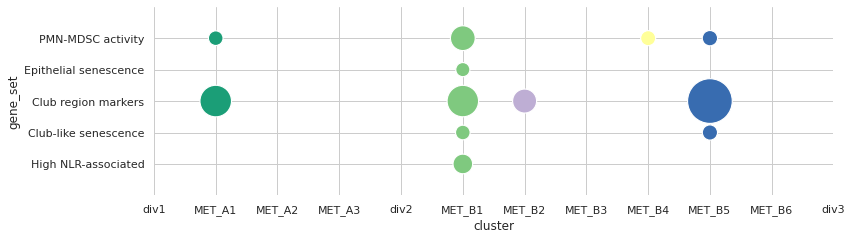

In [101]:
plot_df = df_corrected_transformed.reset_index(drop=True).melt(ignore_index=False).reset_index()
plot_df = df_corrected_transformed.melt(ignore_index=False).reset_index()

# Rename variables
plot_df.columns = ['gene_set','cluster','value']

plot_df['cluster'] = pd.Categorical(plot_df['cluster'],categories=df_corrected_transformed.columns)


# Dark2 with first 6 colors + first 3 repeated to get the column match
color_pal = ['#000000','#1b9e77', '#d95f02', '#7570b3','#000000','#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f','#000000']
sns.set_theme(style='whitegrid',palette=sns.color_palette(color_pal))

fig, ax = plt.subplots(figsize=(12,3.5))
sns.scatterplot(plot_df,
                x='cluster',
                y='gene_set',
                size='value',
                hue='cluster',
                sizes=(200,2000),
                legend=False
                
                )

ax.set_xticks(df_corrected_transformed.columns)
ax.set_ylim(5,-1)
ax.set_title('')

ax.set_frame_on(False)
plt.tight_layout()
plt.savefig('./plots/met_samples/enrichment_dotplot_met_samples.pdf')
plt.show()

# Save plot source data
plot_df.to_excel('./source_data/figure_5e.xlsx')

## Supplementary plots

In [10]:
region_signatures_to_test = {
    'Tumor': check_top_markers('Tumor')['gene'].tolist(),
    'Luminal': check_top_markers('Luminal epithelium')['gene'].tolist(),
    'Basal': check_top_markers('Basal epithelium')['gene'].tolist(),
    'Club': check_top_markers('Club epithelium')['gene'].tolist(),
    'Immune': check_top_markers('Immune')['gene'].tolist(),
    'Endothelium': check_top_markers('Endothelium')['gene'].tolist(),
    'Fibroblast': check_top_markers('Fibroblast')['gene'].tolist(),
    'Muscle': check_top_markers('Muscle')['gene'].tolist(),
}

sample_ids = {
    samples[0]:'A',
    samples[1]:'B',
    samples[2]:'C',
    samples[3]:'D',
}

samples_palettes = {
    samples[0]:'Dark2',
    samples[1]:'Accent',
    samples[2]:'tab10',
    samples[3]:'Paired',

}

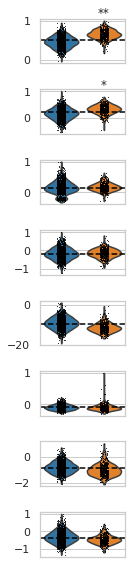

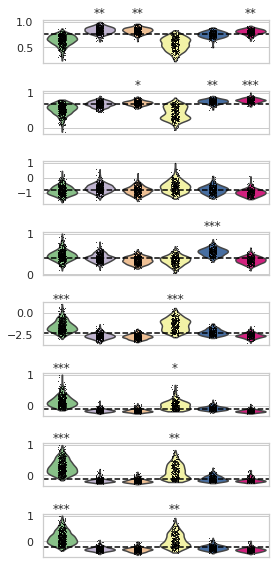

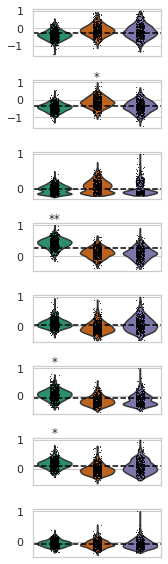

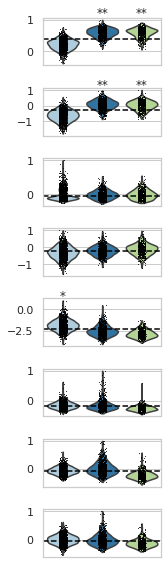

In [140]:
for sample in samples:
#sample = samples[1]

    dat = sc.read_h5ad('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))

    cluster_order = dat.obs['leiden'].cat.categories.tolist()

    fig, axes = plt.subplots(8,1,figsize=(1 + 0.5*len(cluster_order),8))

    for idx,k in enumerate(region_signatures_to_test):
        
        ax = axes[idx]
        pal = samples_palettes[sample]
        sample_id = sample_ids[sample]

        sns.set_theme(style='whitegrid',palette=pal)


        sc.tl.score_genes(dat,gene_list=region_signatures_to_test[k],score_name=k,use_raw=True)
        dat.obs[k] = dat.obs[k]/dat.obs[k].max() # Scale the scores

        score_median = dat.obs[k].median()


        ax.axhline(y=score_median,color='black',linestyle='--')

        sc.pl.violin(dat,keys=k,groupby='leiden',
                    #inner='box',
                    jitter=True,
                    ax=ax,show=False
                    )

        ax.set_xticklabels('')
        ax.set_xlabel('')
        ax.set_ylabel(None)
        ax.set_title('')

        for cl in cluster_order:
            scores_cl = dat.obs[dat.obs['leiden']==cl][k]
            scores_other = dat.obs[~(dat.obs['leiden']==cl)][k]

            # Calculate t-test p-value
            stat, pval = ttest_ind(scores_cl,scores_other)

            cl_scores_desc = scores_cl.describe(percentiles=np.arange(0.1,1,0.1))

            if cl_scores_desc['10%'] >= score_median:
                ax.text(x=cl,y=1.1,s='***',ha='center')
            
            elif cl_scores_desc['20%'] >= score_median:
                ax.text(x=cl,y=1.1,s='**',ha='center')

            elif cl_scores_desc['30%'] >= score_median:
                ax.text(x=cl,y=1.1,s='*',ha='center')



        #ax.set_frame_on(False)
    plt.tight_layout()
    plt.savefig('./plots/met_samples/{}_cluster_violins_all_regions_violin_plot.pdf'.format(sample))
        
    plt.show()


### Enrichment dotplot

In [84]:
enrichment_res_df = pd.DataFrame(index=region_signatures_to_test.keys())
for sample in list(sample_ids.keys()):

    dat = sc.read_h5ad('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))

    enrichment_pvalues_dict = {}
    for k in region_signatures_to_test:
        pvals = check_cluster_enrichment(dat,region_signatures_to_test[k],return_pvals=True)
        enrichment_pvalues_dict[k] = pvals

    res_df = pd.DataFrame(enrichment_pvalues_dict,
            index=[sample+ '_' + str(c) for c in list(np.arange(0,len(pvals))+1)]).T
    
    enrichment_res_df = pd.concat([enrichment_res_df,res_df],axis=1,ignore_index=False)


# Assuming your DataFrame is named 'df' and contains p-values
p_values = enrichment_res_df.values

# Perform FDR correction
reject, corrected_p_values = fdrcorrection(p_values.flatten())

# Reshape the corrected p-values to match the original DataFrame shape
corrected_p_values = corrected_p_values.reshape(enrichment_res_df.shape)

# Create a new DataFrame with the corrected p-values
df_corrected = enrichment_res_df.copy()
df_corrected[:] = corrected_p_values


In [ ]:
df_corrected_transformed = -np.log10(df_corrected)
df_corrected_transformed[df_corrected_transformed <= -np.log10(0.05)] = np.nan

cols1 = df_corrected_transformed.columns[:3].tolist()
cols2 = df_corrected_transformed.columns[3:9].tolist()
cols3 = df_corrected_transformed.columns[9:11].tolist()
cols4 = df_corrected_transformed.columns[11:14].tolist()

idx_list = df_corrected_transformed.index.tolist()

# Add padding to the dataframe
df_corrected_transformed['div1'] = np.nan
df_corrected_transformed['div2'] = np.nan
df_corrected_transformed['div3'] = np.nan

df_corrected_transformed = df_corrected_transformed[cols1 + ['div1'] + cols2 + ['div2'] + cols3 + ['div3'] + cols4]

# Clip the scale to 10^-100
#plot_df = df_corrected_transformed.clip(upper=100)
plot_df = df_corrected_transformed.reset_index(drop=True).melt(ignore_index=False).reset_index()

plot_df['variable'] = pd.Categorical(plot_df['variable'],categories=df_corrected_transformed.columns)

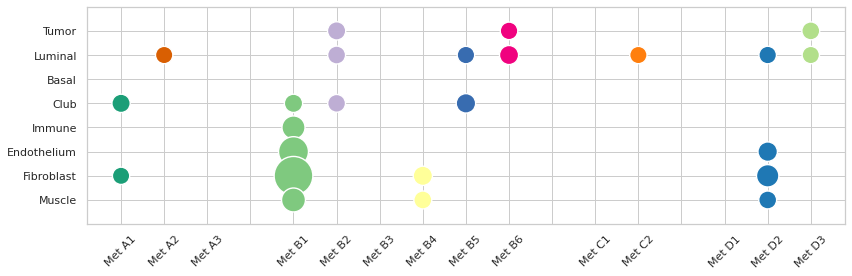

In [161]:
# Dark2 with first 6 colors + first 3 repeated to get the column match
color_pal = (
    sns.color_palette(list(samples_palettes.values())[0],3).as_hex() + ['#000000'] +
    sns.color_palette(list(samples_palettes.values())[1],6).as_hex() + ['#000000'] + 
    sns.color_palette(list(samples_palettes.values())[2],2).as_hex() + ['#000000'] + 
    sns.color_palette(list(samples_palettes.values())[3],3).as_hex()
)
             


sns.set_theme(style='whitegrid',palette=sns.color_palette(color_pal))

fig, ax = plt.subplots(figsize=(12,4))
sns.scatterplot(plot_df,
                x='variable',
                y='index',
                size='value',
                hue='variable',
                sizes=(300,1500),
                legend=False
                
                )


x_ticklabels = (
    ['Met {}{}'.format('A',str(cl)) for cl in np.arange(3) + 1] + [''] + 
    ['Met {}{}'.format('B',str(cl)) for cl in np.arange(6) + 1] + [''] + 
    ['Met {}{}'.format('C',str(cl)) for cl in np.arange(2) + 1] + [''] + 
    ['Met {}{}'.format('D',str(cl)) for cl in np.arange(3) + 1] 
 
)

y_ticklabels = (
    [''] +
    [r.split(' ')[0] for r in regions] +
    ['']
)

ax.set_xticklabels(x_ticklabels,rotation=45)

ax.set_ylim(8,-1)
ax.set_yticklabels(y_ticklabels)
#ax.set_yticklabels('',rotation=20)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')

#ax.set_frame_on(False)
plt.tight_layout()
plt.savefig('./plots/met_samples/enrichment_dotplot_region_markers_all_samples.pdf')
plt.show()